<a href="https://colab.research.google.com/github/jhChoi1997/EE488_AI_Convergence_Capstone_Design_Anomaly_Detection_2022spring/blob/main/rotnet_temp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **practice 2-3 : Anomaly Detection using Self-supervised learning (RotNet)**

code implementation is referenced https://github.com/d4nst/RotNet

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt
import torchsummary
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
plt.rc('font', size=20)

You can change the hyperparameter below.
Parameter 'ANOMALY_NUM' means which number to set as an anomaly.

In [4]:
EPOCHS = 20
BATCH = 32
ANOMALY_NUM = 9

The dataset for anomaly detection is composed of normal data and anomaly data. Normal data can be seen in the train, validation, and test dataset, but anomaly data is not in the train dataset. Here 0 to 8 will be used as normal data, and 9 will be used as anomaly data.

In [5]:
mnist_train = datasets.MNIST(root='MNIST_data/', train=True, transform=ToTensor(), download=True)
mnist_test = datasets.MNIST(root='MNIST_data/', train=False, transform=ToTensor(), download=True)

train_x = torch.tensor([mnist_train[i][0].numpy() for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM])
train_num = torch.tensor([mnist_train[i][1] for i, v in enumerate(mnist_train) if v[1] != ANOMALY_NUM])
train_num_oh = F.one_hot(train_num)
# add rotate angle
train_degree = torch.randint(0,359,(train_x.shape[0],))

unseen_x = torch.tensor([v[0].numpy() for v in mnist_test])
unseen_num = torch.tensor([v[1] for v in mnist_test])
unseen_y = torch.tensor([0 if v[1] != ANOMALY_NUM else 1 for v in mnist_test])


val_x = unseen_x[:int(len(unseen_x) / 2)]
val_num = unseen_num[:int(len(unseen_x) / 2)]
val_num_oh = F.one_hot(val_num)
val_num_oh = torch.cat((val_num_oh[:,0:ANOMALY_NUM],val_num_oh[:,ANOMALY_NUM+1:]), dim=1)
val_y = unseen_y[:int(len(unseen_y) / 2)]
val_degree = torch.randint(0,359,(val_x.shape[0],))
test_x = unseen_x[int(len(unseen_x) / 2):]
test_num = unseen_num[int(len(unseen_x) / 2):]
test_num_oh = F.one_hot(test_num)
test_num_oh = torch.cat((test_num_oh[:,0:ANOMALY_NUM],test_num_oh[:,ANOMALY_NUM+1:]), dim=1)
test_y = unseen_y[int(len(unseen_y) / 2):]
test_degree = torch.randint(0,359,(test_x.shape[0],))
train_dataset = TensorDataset(train_x, train_num_oh, train_degree)
val_dataset = TensorDataset(val_x, val_num_oh, val_y, val_degree)
test_dataset = TensorDataset(test_x, test_num_oh, test_y, test_degree)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


Dataset length is like below.

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

54051
5000
5000


In [7]:
import cv2

In [8]:
def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image = image.cpu().numpy()
    angle = angle.cpu().numpy()
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(image,affine_mat,(new_w, new_h),flags=cv2.INTER_LINEAR)

    # resize as original size

    result = cv2.resize(result,image_size, interpolation=cv2.INTER_AREA)

    return torch.tensor(result)

You will use classifier (FCN) for practice

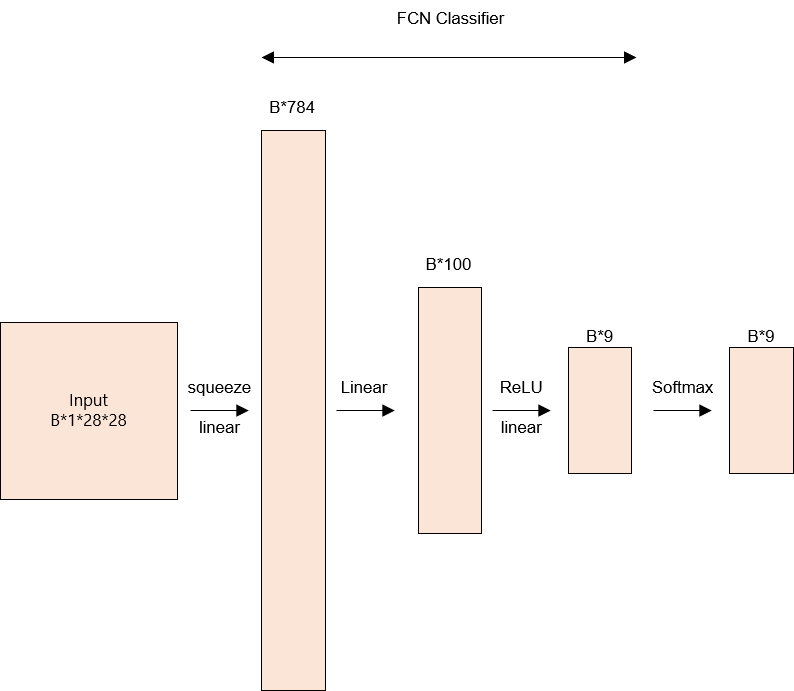

In [9]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1,64,(4,4),(2,2)),
            nn.ReLU(),
            nn.Conv2d(64,64,(4,4),(2,2)),
            nn.ReLU(),
        )
        self.regression_model = nn.Sequential(
            nn.Linear(1600,360),

        )

    def forward(self, x):
        out = self.feature_extractor(x)

        out = out.reshape(x.size(0),-1)

        out = self.regression_model(out)


        return out

In [10]:
model = ClassificationModel().to(device)
print(model)

ClassificationModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
  )
  (regression_model): Sequential(
    (0): Linear(in_features=1600, out_features=360, bias=True)
  )
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
def anomaly_score(logits, true_angle): #modify here as angle error
    pred_angle = torch.argmax(logits, dim=1)
    angle_diff = torch.abs(true_angle - pred_angle)

    return angle_diff
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, y in enumerate(dataloader):
        
        # rotate image
        img = y[0]
        for img_idx in range(y[0].shape[0]):
            img[img_idx,0,:,:] = rotate(y[0][img_idx,0,:,:],y[2][img_idx])

        pred = model(img.to(device))

        loss = loss_fn(pred, F.one_hot(y[2].to(device),num_classes=360).float())
        

        for idata in range(pred.shape[0]):

            iloss = loss_fn(pred[idata:idata+1,:], F.one_hot(y[2][idata:idata+1].to(device),num_classes=360).float())
            losses.append(iloss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0:
            loss, current = loss.item(), batch * pred.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    return np.mean(losses)

Anomaly score is calculated in validation and test. 1 - Maximum Softmax Probability is commonly used as an anomaly score when using classification as a pretext task. Since the model has the label of normal only, the model may predict anomaly data as a normal class with lower probability (Under-confident).

In [13]:
def test(dataloader, model, loss_fn, anomaly_score, draw_mode = False):
    model.eval()

    y_true, y_pred = [], []

    normal_loss = []
    normal_scores = []
    anomaly_scores  =[]

    with torch.no_grad():
      
        for batch, num, anomaly, degree in dataloader:

            batch = batch.to(device)
            num = num.to(device)
            anomaly = anomaly.to(device)
            degree = degree.to(device)

            # rotate here

            # rotate image
            img = batch
            for img_idx in range(batch.shape[0]):
                img[img_idx,0,:,:] = rotate(batch[img_idx,0,:,:],degree[img_idx])

            output = model(img)

            for idata in range(output.shape[0]):

                iloss = loss_fn(output[idata:idata+1,:], F.one_hot(degree[idata:idata+1].to(device),num_classes=360).float())
                iscore = anomaly_score(output[idata:idata+1,:],degree[idata:idata+1])
                if anomaly[idata] == 0:
                    normal_loss.append(iloss)
                    normal_scores.append(iscore)
                elif anomaly[idata] == 1:
                    anomaly_scores.append(iscore)


            score = anomaly_score(output,degree)

            y_true.extend(anomaly.tolist())
            y_pred.extend(score.tolist())

    roc_auc = metrics.roc_auc_score(y_true, y_pred)

    if draw_mode:
        fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
        plt.figure(figsize=(10,10))
        plt.plot(fpr,tpr)
        plt.title('ROC curve')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


    print(f'AUC: {roc_auc:>0.3f}')
    normal_loss = [i.item() for i in normal_loss]
    normal_scores = [i.item() for i in normal_scores]
    anomaly_scores = [i.item() for i in anomaly_scores]

    normal_loss_mean = np.mean(normal_loss)
    normal_score_mean = np.mean(normal_scores)
    anomaly_score_mean = np.mean(anomaly_scores)

    print(f'normal loss : {normal_loss_mean}')

    return roc_auc.item(), normal_loss_mean, normal_score_mean, anomaly_score_mean, normal_scores, anomaly_scores

See how CCE loss and AUC changes during training.
Loss is calculated during train and AUC is calculated during validation.

In [14]:
train_losses = []
val_normal_losses= []
val_normal_scores = []
val_anomaly_scores = []
roc_auc = []

best_auc = 0.0
best_model = model.to(device)

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    auc,val_normal_loss, val_normal_score, val_anomaly_score, _, _ = test(val_dataloader, model, loss_fn, anomaly_score)

    train_losses.append(train_loss)
    val_normal_losses.append(val_normal_loss)
    val_normal_scores.append(val_normal_score)
    val_anomaly_scores.append(val_anomaly_score)

    roc_auc.append(auc)

    if auc > best_auc:
        best_model, best_auc = model, auc

Epoch 1
-------------------------------
loss: 5.890168  [    0/54051]
loss: 5.260253  [ 9600/54051]
loss: 5.266535  [19200/54051]
loss: 4.678020  [28800/54051]
loss: 5.119953  [38400/54051]
loss: 4.904262  [48000/54051]
AUC: 0.548
normal loss : 4.864387157506177
Epoch 2
-------------------------------
loss: 4.578995  [    0/54051]
loss: 4.471487  [ 9600/54051]
loss: 4.797342  [19200/54051]
loss: 4.260648  [28800/54051]
loss: 4.887000  [38400/54051]
loss: 4.696985  [48000/54051]
AUC: 0.549
normal loss : 4.7418819010257724
Epoch 3
-------------------------------
loss: 4.327095  [    0/54051]
loss: 4.218259  [ 9600/54051]
loss: 4.645205  [19200/54051]
loss: 4.091709  [28800/54051]
loss: 4.736200  [38400/54051]
loss: 4.549230  [48000/54051]
AUC: 0.562
normal loss : 4.66823044068047
Epoch 4
-------------------------------
loss: 4.171474  [    0/54051]
loss: 4.041575  [ 9600/54051]
loss: 4.518621  [19200/54051]
loss: 3.992849  [28800/54051]
loss: 4.640774  [38400/54051]
loss: 4.441061  [4800

<Figure size 432x288 with 0 Axes>

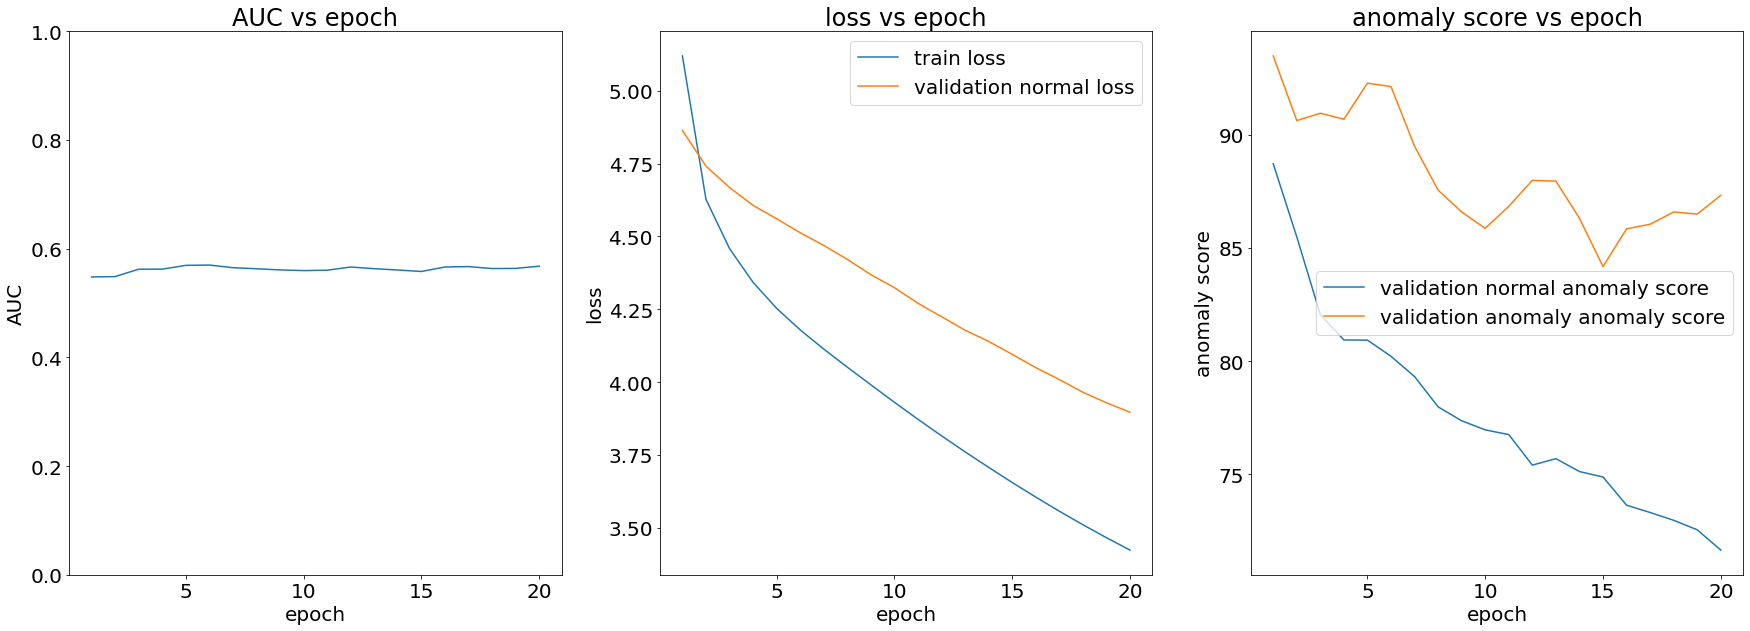

In [15]:
plt.clf()
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(list(range(1,len(roc_auc)+1)),roc_auc)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.title('AUC vs epoch')
plt.ylim([0, 1])

plt.subplot(1,3,2)
plt.plot(list(range(1,len(train_losses)+1)),train_losses)
plt.plot(list(range(1,len(val_normal_losses)+1)),val_normal_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend(['train loss', 'validation normal loss'])

plt.subplot(1,3,3)
plt.plot(list(range(1,len(val_normal_scores)+1)),val_normal_scores)
plt.plot(list(range(1,len(val_anomaly_scores)+1)),val_anomaly_scores)
plt.xlabel('epoch')
plt.ylabel('anomaly score')
plt.title('anomaly score vs epoch')
plt.legend(['validation normal anomaly score','validation anomaly anomaly score'])

Let's see performance on the test data.

AUC: 0.568
normal loss : 3.7097387661755032


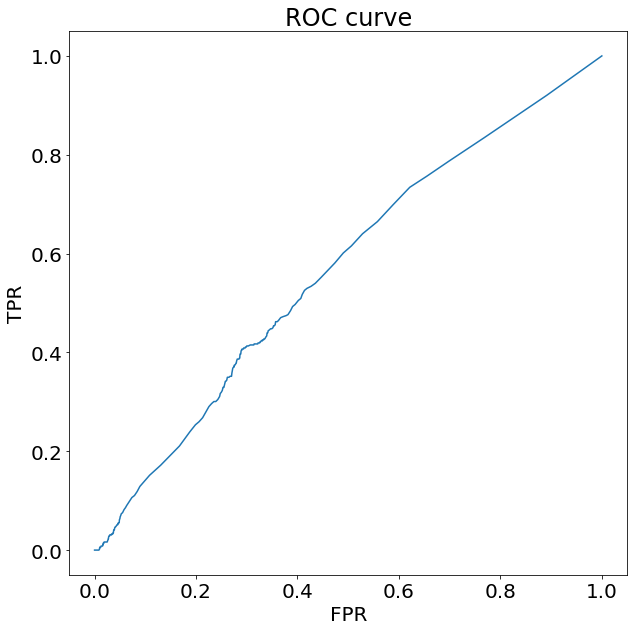

In [16]:
test_auc,test_normal_loss, test_normal_score, test_anomaly_score, test_normal_scores, test_anomaly_scores = test(test_dataloader, best_model, loss_fn, anomaly_score, draw_mode=True)

The let's see anomaly score of normal / anomaly data.

<Figure size 720x720 with 0 Axes>

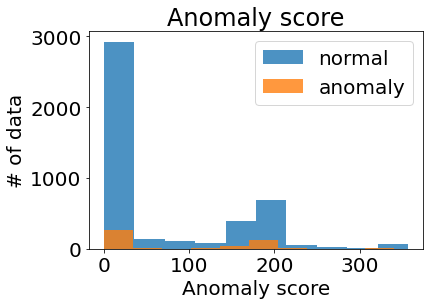

<Figure size 720x720 with 0 Axes>

In [17]:
plt.hist(test_normal_scores, alpha = 0.8)
plt.hist(test_anomaly_scores, alpha = 0.8)
plt.title('Anomaly score')
plt.xlabel('Anomaly score')
plt.ylabel('# of data')
plt.legend(['normal','anomaly'])
plt.figure(figsize=(10,10))

Below code plots figure of the original input image and predicted probabilities.

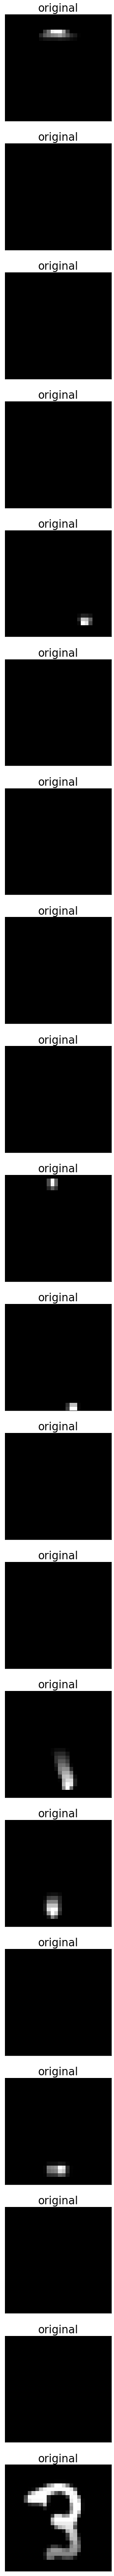

In [21]:
n = 20
plt.figure(figsize=(40, 80))

for i in range(n):
    input_image = rotate(test_dataset[i][0].to(device),test_dataset[i][3])
    #pred_prob = torch.softmax(best_model(input_image.unsqueeze(0)),dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu())
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.tight_layout()

plt.show()

RuntimeError: ignored

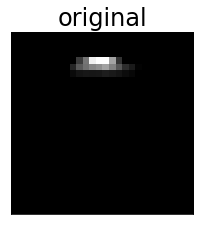

In [20]:
n = 20
plt.figure(figsize=(40, 80))

for i in range(n):
    input_image = rotate(test_dataset[i][0].to(device),test_dataset[i][3])
    #pred_prob = torch.softmax(best_model(input_image.unsqueeze(0)),dim=1).cpu().detach().squeeze().numpy()

    ax = plt.subplot(n, 2, 2*i+1)
    plt.imshow(input_image[0].cpu())
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    pred_prob = torch.softmax(best_model(input_image.unsqueeze(0)),dim=1).cpu().detach().squeeze().numpy()
    ax2 = plt.subplot(n, 2, 2*i+2)
    ax2.set_ylim([0,1])
    classify_as = np.array(list(range(ANOMALY_NUM)) + list(range(ANOMALY_NUM+1,9)))
    plt.bar(classify_as, pred_prob, width = 0.5, tick_label = [str(i) for i in classify_as])
    #plt.imshow(output_image[0].squeeze().detach().cpu())
    plt.title('predicted probability')
    plt.tight_layout()

plt.show()

As you see, normal data (0 to 8) is predicted with a high probability compared to anomaly data (9). 

This means normal data have higher MSP, which is anomaly score, and anomaly data have lower MSP.

Using this difference of anomaly score, anomaly detection can be done.